In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Modify the parameters before running
---


In [2]:
normal_test_path = './data/norm_test.csv'
anomaly_test_path = './data/features_anom_scaled.csv'
window_size = 69
flattened_size = 2553
model_path = './cae-69.pt'

---

In [3]:
norm_test = np.genfromtxt(normal_test_path, delimiter=',', dtype=np.float32)
anom_test = np.genfromtxt(anomaly_test_path, delimiter=',', dtype=np.float32)

In [4]:
np.random.shuffle(norm_test)
np.random.shuffle(anom_test)

In [5]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential( # input 69x37x1
            
            # conv1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2), # cols: (37-3)/2+1 = 18
                                                                                # rows: (69-3)/2+1 = 34
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 18/2=9, 34/2=17 => output is 17x9x16
            
            # conv2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2), # cols: (9-3)/2+1 = 4  
                                                                                 # rows: (17-3)/2+1 = 8 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 4/2 = 2, 8/2 = 4 => output is 4x2x32 = 256
            
        )
        
        # dense layers
        self.dense1 = nn.Linear(256, 128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64, 128)
        self.dense4 = nn.Linear(128, 256)
        
        self.decoder = nn.Sequential(
            
            # convt1
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # convt2
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = torch.nn.functional.relu(self.dense1(x.view(x.size(0), -1))) # flatten tensor
        x = torch.nn.functional.relu(self.dense2(x))
        x = torch.nn.functional.relu(self.dense3(x))
        x = torch.nn.functional.relu(self.dense4(x))
        x = self.decoder(x.view(x.size(0), 32, 4, 2)) # reshape tensor to 32x2x2
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'

cae = CAE().to(device)
cae.load_state_dict(torch.load(model_path))
cae.eval()

CAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense1): Linear(in_features=256, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=64, bias=True)
  (dense3): Linear(in_features=64, out_features=128, bias=True)
  (dense4): Linear(in_features=128, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_

In [7]:
def reconstruction_mse(true, pred):
    true = true.reshape(-1, flattened_size)
    pred = pred.reshape(-1, flattened_size)
    
    return np.sum((true-pred)**2, axis=1) / flattened_size

In [8]:
# random sample 200 rows from norm and anom
# search threshold range => arange(0.1, 1, 0.05)
# for each threshold value, find fp percentage and fn percentage and calculate f = fp*0.33 + fn*0.67
# find the threshold value with the lowest f
# repeat 5 times, take the average

In [9]:
sample_size = 200

thres_list = []

for a in range(0, 5):
    norm_subset = norm_test[a*sample_size:(a+1)*sample_size]
    anom_subset = anom_test[a*sample_size:(a+1)*sample_size]
    
    input_tensor = torch.from_numpy(norm_subset.reshape(-1, 1, window_size, 37)).to(device)
    norm_subset_recon = cae(input_tensor)
    loss_norm = reconstruction_mse(norm_subset, norm_subset_recon.detach().numpy())

    input_tensor = torch.from_numpy(anom_subset.reshape(-1, 1, window_size, 37)).to(device)
    anom_subset_recon = cae(input_tensor)
    loss_anom = reconstruction_mse(anom_subset, anom_subset_recon.detach().numpy())
    
    
    lowest_score = 100
    lowest_score_thres = 0
    
    for thres in np.arange(0.5, 1, 0.01):
        # false positive as percentage:
        fpp = (loss_norm >= thres).sum() / sample_size
        
        # false negative as percentage:
        fnp = (loss_anom < thres).sum() / sample_size
        
        score = fpp*0.33 + fnp*0.67
#         print(thres, fpp, fnp, score)
        
        if score <= lowest_score:
            lowest_score = score
            lowest_score_thres = thres
            
#     print(
    thres_list.append(lowest_score_thres)

recon_loss_threshold = np.mean(thres_list)

In [10]:
print(recon_loss_threshold)

0.7440000000000002


### testing against normal data

In [11]:
input_tensor = torch.from_numpy(norm_test[1000:].reshape(-1, 1, window_size, 37)).to(device)
reconstructed_window = cae(input_tensor)

In [12]:
loss_norm = reconstruction_mse(norm_test[1000:], reconstructed_window.detach().numpy())

### testing against anomalous data

In [13]:
input_tensor = torch.from_numpy(anom_test[1000:].reshape(-1, 1, window_size, 37)).to(device)
reconstructed_window = cae(input_tensor)

In [14]:
loss_anom = reconstruction_mse(anom_test[1000:], reconstructed_window.detach().numpy())

---

In [15]:
norm_true = np.array(['NORMAL' for i in norm_test[1000:]])
anom_true = np.array(['ANOMALOUS' for i in anom_test[1000:]])
comb_true = np.concatenate((norm_true, anom_true))

(0.0, 4.0)

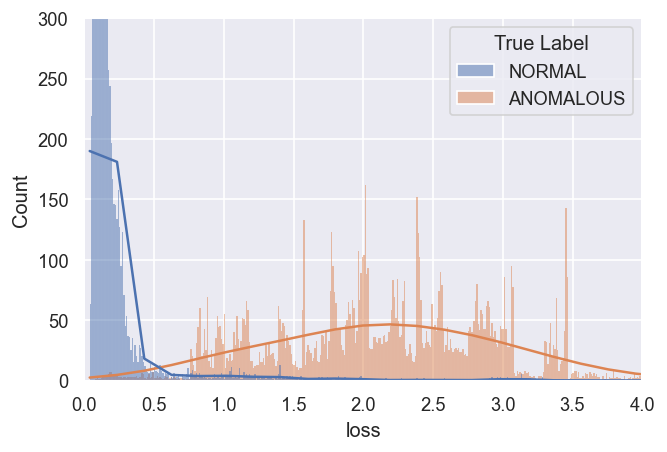

In [32]:
comb_loss = np.concatenate((loss_norm, loss_anom))
df_loss = pd.DataFrame({'True Label': comb_true, 'loss': comb_loss})
fig, ax = plt.subplots(dpi=120)
sns.histplot(data=df_loss, x='loss', hue='True Label', binwidth=0.01, fill=True, kde=True, ax=ax)
ax.set_ylim(0, 300)
ax.set_xlim(0, 4)

In [17]:
prediction_norm = ['NORMAL' if l < recon_loss_threshold else 'ANOMALOUS' for l in loss_norm]
# unique, counts = np.unique(prediction, return_counts=True)
# prediction_counts = pd.DataFrame(np.array((unique, counts)).T, columns=['label', 'count'])

In [18]:
norm_pred = np.array(['NORMAL' if l < recon_loss_threshold else 'ANOMALOUS' for l in loss_norm])

In [19]:
df_prediction_norm = pd.DataFrame(data=np.array(prediction_norm), columns=['label'])
df_prediction_norm['label'].value_counts()

NORMAL       8027
ANOMALOUS     427
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

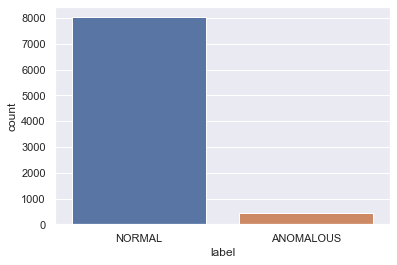

In [33]:
sns.countplot(x='label', data=df_prediction_norm)

In [21]:
prediction_anom = ['NORMAL' if l < recon_loss_threshold else 'ANOMALOUS' for l in loss_anom]

In [22]:
anom_pred = np.array(['NORMAL' if l < recon_loss_threshold else 'ANOMALOUS' for l in loss_anom])

In [23]:
df_prediction_anom = pd.DataFrame(data=np.array(prediction_anom), columns=['label'])
df_prediction_anom['label'].value_counts()

ANOMALOUS    10626
NORMAL         185
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

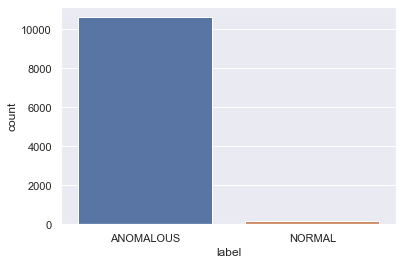

In [34]:
sns.countplot(x='label', data=df_prediction_anom)

In [25]:
comb_pred = np.concatenate((norm_pred, anom_pred))

<AxesSubplot:xlabel='Predicted Label', ylabel='True Label'>

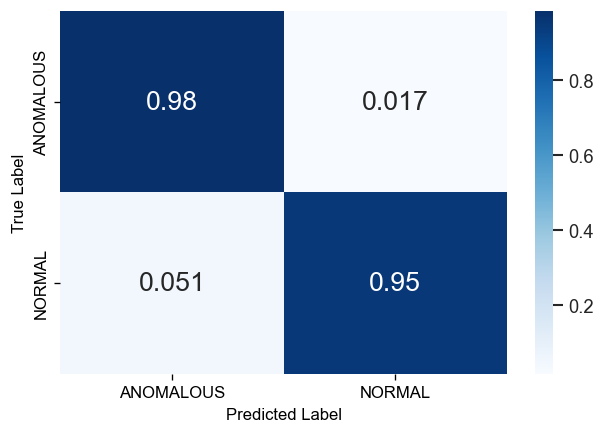

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(comb_true, comb_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmn, columns=np.unique(comb_true), index=np.unique(comb_true))
df_cm.index.name='True Label'
df_cm.columns.name = 'Predicted Label'
fig, ax = plt.subplots(dpi=120)
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size': 16})

### testing against cherry-picked broken data (__DO NOT RUN__ for now)

In [27]:
failure_index = np.genfromtxt('./data/broken_index.csv', delimiter=',', dtype=int)

In [28]:
broken = np.genfromtxt('./data/features_broken_scaled.csv', delimiter=',', dtype=np.float32)

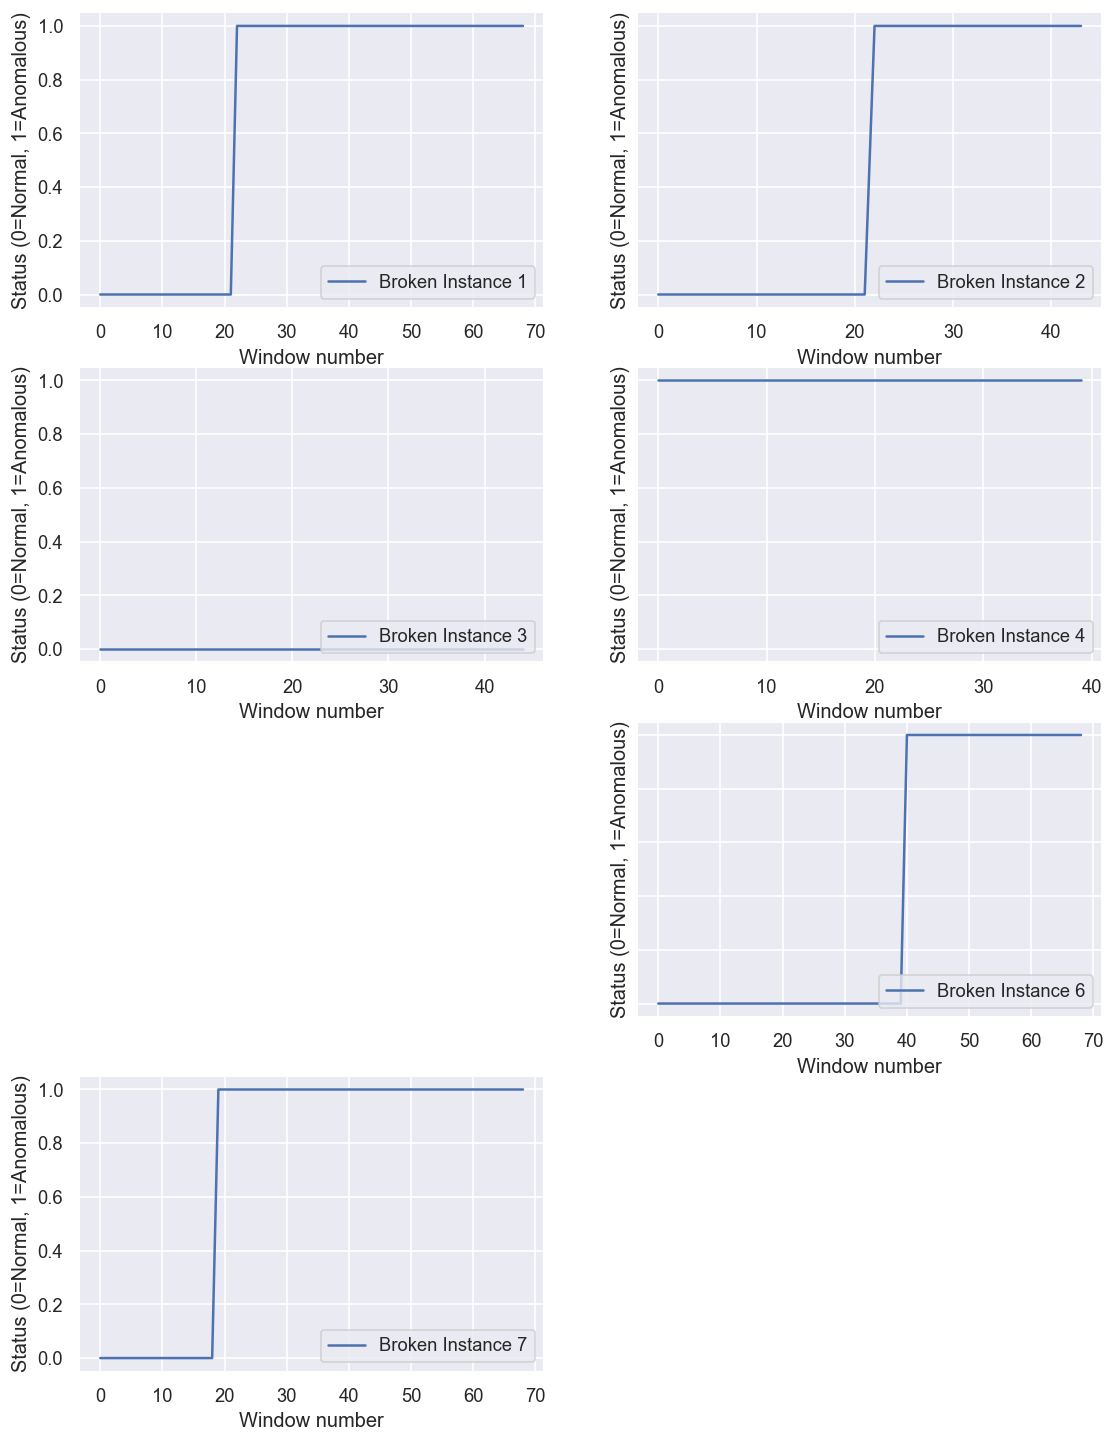

In [31]:
device='cpu'
fig, ax = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(11, 15), sharey=True)

for idx in range(0, 7):
    if idx == 4:
        continue
    
    length = (failure_index==idx).sum()
    
    broken_subset = broken[failure_index==idx]

    input_tensor = torch.from_numpy(broken_subset.reshape(-1, 1, window_size, 37)).to(device)
    reconstructed_window = cae(input_tensor)

    loss = reconstruction_mse(broken_subset, reconstructed_window.detach().numpy())

    prediction = [0 if l < 0.5 else 1 for l in loss]

    ax[int(idx/2), idx%2].plot(np.arange(0, length,1), prediction, 'b-', label='Broken Instance {}'.format(idx+1))
    ax[int(idx/2), idx%2].legend(loc='lower right')
    ax[int(idx/2), idx%2].set_ylabel('Status (0=Normal, 1=Anomalous)')
    ax[int(idx/2), idx%2].set_xlabel('Window number')
    
fig.delaxes(ax[3, 1])
fig.delaxes(ax[2, 0])